In [23]:
from graphviz import Digraph
import torch
def trace(root):

    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label="{ %s | %s | grad %s}" % (n.label, n.data.shape, str(n.grad.detach().cpu().numpy())), shape='record')

        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [24]:
def unbroadcast(target, grad):
    while grad.dim() > target.dim():
        grad = grad.sum(dim=0)
    for i, size in enumerate(target.size()):
        if size == 1:
            grad = grad.sum(dim=i, keepdim=True)
    return grad

In [25]:
import torch

class Value:
    def __init__(self, value, _children=(), label="", _op=""):
        self.data = value
        self._prev = _children
        self._backward = lambda: None
        self.label = label
        self._op = _op
        self.grad = torch.zeros_like(value)

    def __add__(self, other):
        if isinstance(other, Value):
            out = Value(self.data + other.data, _children=(self, other), _op="+")
            def _backward():
                self.grad += unbroadcast(self.data, out.grad)
                other.grad += unbroadcast(other.data, out.grad)
            out._backward = _backward
            return out
        elif isinstance(other, torch.Tensor):
            out = Value(self.data + other, _children=(self,), _op="+")
            def _backward():
                self.grad += unbroadcast(self.data, out.grad)
            out._backward = _backward
            return out
        else:
            raise TypeError("Unsupported operand type(s) for +: 'Value' and '{}'".format(type(other)))

    def __matmul__(self, other):
        if isinstance(other, Value):
            out = Value(self.data @ other.data, _children=(self, other), _op="@")
            def _backward():
                self.grad += unbroadcast(self.data, out.grad @ other.data.T)
                other.grad += unbroadcast(other.data, self.data.T @ out.grad)
            out._backward = _backward
            return out
        elif isinstance(other, torch.Tensor):
            out = Value(self.data @ other, _children=(self,), _op="@")
            def _backward():
                self.grad += unbroadcast(self.data, out.grad @ other.T)
            out._backward = _backward
            return out
        else:
            raise TypeError("Unsupported operand type(s) for @: 'Value' and '{}'".format(type(other)))

    def backward(self):
        # Initialize the gradient of the output value
        self.grad = torch.ones_like(self.data)
        # Propagate the gradients backward through the computation graph
        stack = [self]
        while stack:
            node = stack.pop()
            node._backward()
            stack.extend(node._prev)

    def __repr__(self):
        return str(f'Value: {self.data}')

    def __str__(self):
        return str(f'Value :{self.data}')


In [26]:
# a = torch.tensor([[1, 2],[3,4]]).double()
# b = torch.tensor([[10, 20], [30, 40]]).double()
# w = torch.tensor([[2,4],[5,1]]).double()

In [27]:
# a = torch.tensor([[10, 12],[23,14]]).double()
# b = torch.tensor([[10, 20], [30, 40]]).double()
# w = torch.tensor([[21,4],[5,12]]).double()

In [28]:
w = torch.randn(1, 1, requires_grad=True)
b = torch.randn(1, 1, requires_grad=True)
a = torch.randn(50, 1, requires_grad=True)

In [29]:
w1 = w.clone().detach().requires_grad_(True)
b1 = b.clone().detach().requires_grad_(True)
a1 = a.clone().detach().requires_grad_(True)

In [70]:
w = torch.randn(1, 1, requires_grad=True)
b = torch.randn(1, 1, requires_grad=True)
a = torch.randn(2, 1, requires_grad=True)
interm = a @ w
z = interm + b

In [73]:
z.grad = torch.ones_like(z.data)

In [74]:
z._backward()

AttributeError: 'Tensor' object has no attribute '_backward'

In [68]:
w, w1

(tensor([[0.3075]], requires_grad=True),
 tensor([[0.3075]], requires_grad=True))

In [31]:
# a = torch.tensor([[1, 2],[3,4]]).double()
# b = torch.tensor([10, 20]).double()
# w = torch.tensor([[2,4],[5,1]]).double()

In [107]:
temp1 = torch.tensor([[3]]).double().requires_grad_(True)

In [108]:
temp2 = torch.tensor([[10],[20]]).double().requires_grad_(True)

In [109]:
temp3 = torch.tensor([[1,2]]).double().requires_grad_(True)

In [110]:
temp1_ = Value(temp1)
temp2_ = Value(temp2)
temp3_ = Value(temp3)


In [111]:
temp4_ = temp2_ @ temp3_

In [122]:
temp_ = temp4_ + temp1_

In [123]:
temp_.grad = torch.ones_like(temp_.data)

In [124]:
temp_._backward()

In [127]:
temp4_.grad

tensor([[2., 2.],
        [2., 2.]], dtype=torch.float64)

In [126]:
temp1_.grad

tensor([[8.]], dtype=torch.float64)

In [143]:
temp3_.grad

tensor([[60., 60.]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [129]:
temp4_._backward()

In [130]:
temp2_.grad

tensor([[6.],
        [6.]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [131]:
temp1_.grad

tensor([[8.]], dtype=torch.float64)

In [42]:
# loss = temp.sum()

In [133]:
temp4 = temp2 @ temp3

In [136]:
temp = temp4 + temp1

In [137]:
loss = temp.sum()

In [138]:
loss.backward()

In [141]:
temp4.grad

/tmp/ipykernel_7451/1087064031.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  temp4.grad


In [142]:
print(temp1.grad,temp2.grad,temp3.grad)


tensor([[4.]], dtype=torch.float64) tensor([[3.],
        [3.]], dtype=torch.float64) tensor([[30., 30.]], dtype=torch.float64)


In [43]:
# loss.backward()

In [44]:
temp2.grad

tensor([[3.],
        [3.]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [45]:
temp1.grad


tensor([[0.]], dtype=torch.float64)

In [46]:
temp3.grad


tensor([[30., 30.]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [47]:
temp2.grad

tensor([[3.],
        [3.]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [48]:
temp1.grad

tensor([[0.]], dtype=torch.float64)

In [49]:
temp.grad = torch.ones_like(temp.data)

In [50]:
temp._backward()

In [75]:
a = Value(a)
a.label = 'a'
b = Value(b)
b.label = 'b'
w = Value(w)
w.label = 'w'

In [76]:
interm = a @ w
interm.label = 'interm'
z = interm + b
z.label = 'z'

In [53]:
# z

In [54]:
# temp = (torch.tensor([[1, 2],[3,4]]) @ torch.tensor([[2,4],[5,1]])) + torch.tensor([[10, 20], [30, 40]])

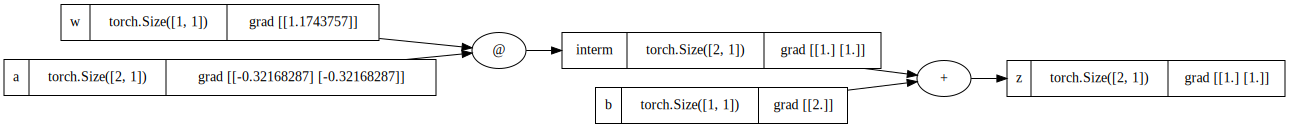

In [80]:
draw_dot(z)

In [78]:
z.grad = torch.ones_like(z.data)

In [79]:
z._backward()
interm._backward()
# (other.grad, other.data, out.grad)

In [82]:
import torch

# Define the calculation
# a1 = torch.tensor([[1, 2],[3,4]], dtype=torch.float32, requires_grad=True)
# w1 = torch.tensor([[2,4],[5,1]], dtype=torch.float32, requires_grad=True)
# b1 = torch.tensor([[10, 20], [30, 40]], dtype=torch.float32, requires_grad=True)

# a1 = torch.tensor([[1, 2],[3,4]], dtype=torch.float32, requires_grad=True)
# w1 = torch.tensor([[2,4],[5,1]],dtype=torch.float32, requires_grad=True)
# b1 = torch.tensor([10, 20], dtype=torch.float32, requires_grad=True)

# a1 = torch.tensor([[10, 12],[23,14]], dtype=torch.float32, requires_grad=True)
# b1 = torch.tensor([[10, 20], [30, 40]],dtype=torch.float32, requires_grad=True)
# w1 = torch.tensor([[21,4],[5,12]], dtype=torch.float32, requires_grad=True)

# w1 = torch.randn(1, 1, requires_grad=True)
# b1 = torch.randn(1, 1, requires_grad=True)
# a1 = torch.randn(100, 1, requires_grad=True)


temp = (a1 @ w1) + b1

# Create a scalar tensor to use as the loss
loss = temp.sum()

# Compute gradients
loss.backward()

# Access gradients of the input tensors
print("Gradient of the a tensor:", a1.grad)
print("Gradient of the w tensor:", w1.grad)
print("Gradient of the b tensor:", b1.grad)


Gradient of the a tensor: tensor([[-0.3217],
        [-0.3217]])
Gradient of the w tensor: tensor([[1.1744]])
Gradient of the b tensor: tensor([[2.]])


In [59]:
# z._backward()

In [83]:
# Access gradients of the input tensors
print("Gradient of the a tensor:", a.grad)
print("Gradient of the w tensor:", w.grad)
print("Gradient of the b tensor:", b.grad)

Gradient of the a tensor: tensor([[-0.3217],
        [-0.3217]], grad_fn=<AddBackward0>)
Gradient of the w tensor: tensor([[1.1744]], grad_fn=<AddBackward0>)
Gradient of the b tensor: tensor([[2.]])


In [61]:
import torch

tensor1 = torch.tensor([1, 2])
tensor2 = torch.tensor([[1, 2], [2, 2]])

result = tensor1.unsqueeze(0) @ tensor2
print(result.squeeze(0).shape)


torch.Size([2])


In [62]:
tensor1.unsqueeze(0).shape

torch.Size([1, 2])

In [63]:
tensor2.shape

torch.Size([2, 2])

In [64]:
tensor1.unsqueeze(0) @ tensor2

tensor([[5, 6]])